1. 导入必要的模块

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2. 定义功能函数

In [2]:
def model_1x(params):
    ''''''
    fx = (params[:, 0] + params[:, 1] + params[:, 2])
    return fx

def model_1y(params):
    ''''''
    fy = params[:, 0] ** 2 + params[:, 1] * 30 + params[:, 2]
    return fy

def model_1z(params):
    ''''''
    fz = (params[:, 0] + params[:, 1])** 2 + params[:, 2]
    return fz

3. 计算损失函数的功能函数定义

In [3]:
def calc_loss1(y1, y2):
    '''计算均方误差''' 
    loss1 = tf.reduce_sum((y1[:, 0] - y2[:, 0]) ** 2)
    return loss1

def calc_loss2(ct):
    '''计算刀轴矢量变化量之和, 作为loss2.
    :param ct: 刀轴矢量, shape为[N, 3]
    '''
    normal_ct = ct / tf.sqrt(tf.reduce_sum(ct ** 2, 1))
    tmp1 = tf.reduce_sum((normal_ct[:, 2 :  - 1] - normal_ct[:, 1 : - 2]) ** 2, 1)
    tmp2 = tf.sqrt(tmp1)
    loss2 = tf.reduce_sum(tmp2)
    return loss2


def calc_loss3(fx, fy, fz):
    '''计算切削力方向的变化量, 作为loss3.'''
    f = tf.stack([fx, fy, fz], axis=1)
    f = tf.reshape(f, [-1, 3])
    d = tf.sqrt(tf.reduce_sum(f**2, 1))
    d = tf.reshape(d, [-1, 1])
    nf = f / d
    tmp1 = tf.reduce_sum((nf[:, 2 : -1] - nf[:, 1 : - 2]) ** 2, 1)
    tmp2 = tf.sqrt(tmp1)
    loss3 = tf.reduce_sum(tmp2)
    return loss3

4. 搭建model2的训练模型

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


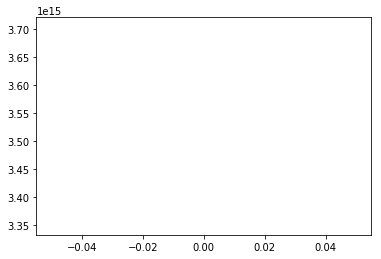

In [4]:
#tf.reset_default_graph()

params1 = tf.placeholder(dtype=tf.float32, shape=[None, 3])
fz_real = model_1z(params1)
fz_exp = fz_real * 0.9

w = tf.Variable(dtype=tf.float32, initial_value=tf.truncated_normal(shape=[1, 5]))
b = tf.Variable(dtype=tf.float32, initial_value=tf.truncated_normal(shape=[5]))

params3 = tf.reshape(fz_exp, [-1, 1])
layer0 = tf.nn.sigmoid(tf.matmul(params3, w) + b)


ww = tf.Variable(dtype=tf.float32, initial_value=tf.truncated_normal(shape=[5, 3]))
bb = tf.Variable(dtype=tf.float32, initial_value=tf.truncated_normal(shape=[3]))
ct = tf.matmul(layer0, ww) + bb

params4 = ct
fz_tobe = model_1z(params4)
fx_tobe = model_1x(params4)
fy_tobe = model_1y(params4)

fx_tobe = tf.reshape(fx_tobe, [-1, 1])
fy_tobe = tf.reshape(fy_tobe, [-1, 1])
fz_tobe = tf.reshape(fz_tobe, [-1, 1])
fz_exp = tf.reshape(fz_exp, [-1, 1])
ct = tf.reshape(ct, [-1, 1])

loss1 = calc_loss1(fz_tobe, fz_exp)
loss2 = calc_loss2(ct)
loss3 = calc_loss3(fx_tobe, fy_tobe, fz_tobe)
loss = 0.8 * loss1 + 0.1 * loss2 + 0.1 * loss3

tf.summary.scalar("loss1", loss1)
tf.summary.scalar("loss2", loss2)
tf.summary.scalar("loss3", loss3)
tf.summary.scalar("loss", loss)
summary = tf.summary.merge_all()


#开始训练
step = tf.train.GradientDescentOptimizer(0.02).minimize(loss)
init = tf.global_variables_initializer()
train_data = np.random.sample([20, 3]) * 10


writer = tf.summary.FileWriter("./logs", tf.get_default_graph())
loss1_vals = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(0, 3000):
        sess.run(step, feed_dict={params1: train_data})
        if i%2 == 0:
            res = sess.run(summary, feed_dict={params1: train_data})
            writer.add_summary(res, i)
        if i % 3 == 0:
            lv = loss1.eval(session=sess, feed_dict={params1: train_data})
            loss1_vals.append(lv)
            
plt.plot(loss1_vals)

In [5]:
len(loss1_vals)
loss1_vals[0:10]

[3526612700000000.0, nan, nan, nan, nan, nan, nan, nan, nan, nan]